# CAT Vs Dog

## 3. 전이학습

- VGG16 살펴보기

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 3.1. 데이터 증식을 사용하지 않은 특성 추출

- 데이터 준비

In [3]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'data/cats_and_dogs/train'
validation_dir = 'data/cats_and_dogs/validation'
test_dir = 'data/cats_and_dogs/test'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

- 모델 정의/컴파일/학습

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.00002),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 0s 177us/step - loss: 0.5956 - acc: 0.6725 - val_loss: 0.4390 - val_acc: 0.8280
Epoch 2/30
2000/2000 [==============================] - 0s 132us/step - loss: 0.4400 - acc: 0.7995 - val_loss: 0.3789 - val_acc: 0.8360
Epoch 3/30
2000/2000 [==============================] - 0s 152us/step - loss: 0.3592 - acc: 0.8435 - val_loss: 0.3302 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 0s 155us/step - loss: 0.3201 - acc: 0.8685 - val_loss: 0.3015 - val_acc: 0.8800
Epoch 5/30
2000/2000 [==============================] - 0s 133us/step - loss: 0.2823 - acc: 0.8855 - val_loss: 0.2934 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 0s 129us/step - loss: 0.2659 - acc: 0.8905 - val_loss: 0.2751 - val_acc: 0.8850
Epoch 7/30
2000/2000 [==============================] - 0s 137us/step - loss: 0.2475 - acc: 0.9050 - val_loss: 0.2626 - val_acc: 0.8990


- 성능평가 시각화

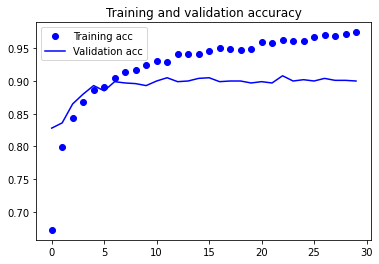

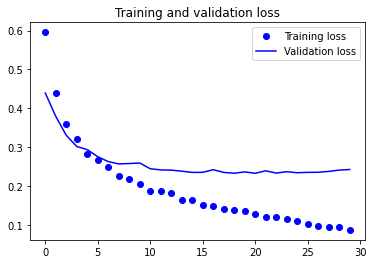

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 3.2. 데이터 증식을 사용한 특성 추출

- 엔드투엔드 모델 정의

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('conv_base를 동결하기 전 가중치의 수:', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 가중치의 수:', len(model.trainable_weights))

conv_base를 동결하기 전 가중치의 수: 30
conv_base를 동결한 후 가중치의 수: 4


- 모델 학습

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 9s 91ms/step - loss: 0.5334 - acc: 0.7465 - val_loss: 0.5108 - val_acc: 0.8420
Epoch 2/30
100/100 [==============================] - 8s 82ms/step - loss: 0.4023 - acc: 0.8305 - val_loss: 0.3464 - val_acc: 0.8740
Epoch 3/30
100/100 [==============================] - 8s 82ms/step - loss: 0.3537 - acc: 0.8485 - val_loss: 0.4269 - val_acc: 0.8520
Epoch 4/30
100/100 [==============================] - 8s 82ms/step - loss: 0.3186 - acc: 0.8650 - val_loss: 0.3326 - val_acc: 0.8930
Epoch 5/30
100/100 [==============================] - 8s 81ms/step - loss: 0.3005 - acc: 0.8795 - val_loss: 0.2137 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 8s 82ms/step - loss: 0.2905 - acc: 0.8830 - val_loss: 0.2922 - val_acc: 0.8950
Epoch 7/30
100/100 [==============================] - 8s 83ms/step - loss: 0.2804 - acc: 0.8890 - val_loss: 0.1686 - v

In [10]:
model.save('cats_and_dogs_small_3.h5')

- 성능평가 시각화

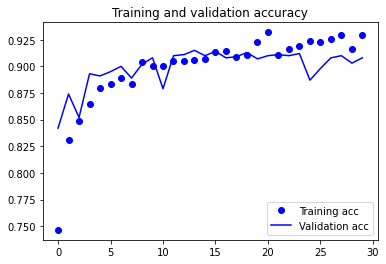

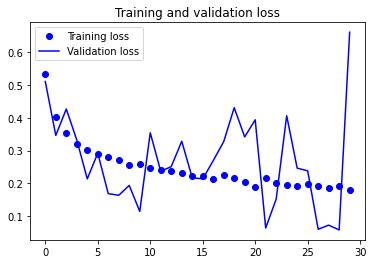

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### 3.3. Fine Tuning

- 특정 층까지만 동결하기

In [12]:
[i.name for i in conv_base.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [13]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
[i.trainable for i in conv_base.layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 9s 91ms/step - loss: 0.1984 - acc: 0.9200 - val_loss: 0.8056 - val_acc: 0.8680
Epoch 2/100
100/100 [==============================] - 8s 83ms/step - loss: 0.1657 - acc: 0.9300 - val_loss: 0.1640 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 8s 83ms/step - loss: 0.1449 - acc: 0.9445 - val_loss: 0.1059 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 8s 83ms/step - loss: 0.1254 - acc: 0.9490 - val_loss: 0.1184 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 8s 83ms/step - loss: 0.1053 - acc: 0.9575 - val_loss: 0.0709 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 8s 82ms/step - loss: 0.0942 - acc: 0.9635 - val_loss: 0.2059 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 9s 85ms/step - loss: 0.0904 - acc: 0.9660 - val_loss: 0.0073 - val_acc: 0.9180
Epoch 8/100
100/100 [==============================] - 8s 83ms

In [15]:
model.save('cats_and_dogs_small_4.h5')

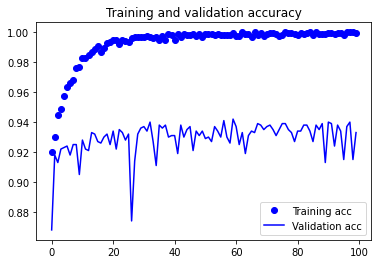

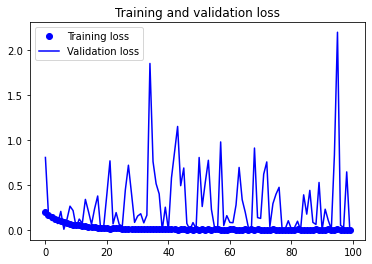

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

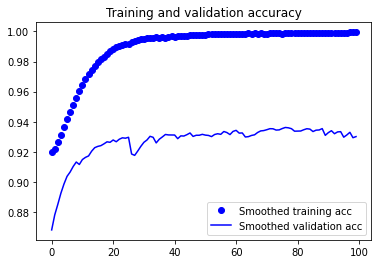

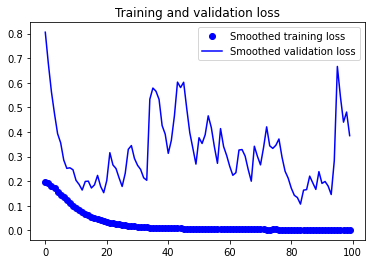

In [17]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

In [18]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9359999895095825
